In [1]:
##########################################################複製區塊
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
import multiprocessing as multi
#setup some constants and parameters
M=2**16
tsim=7e-12/7
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=3000
frq_min = 0.5 #150THz
frq_max = 1.5 #450THz
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 20
nfreq =  1000
#define the starting sum of the result
epsilonA = 2
epsilonB = 13
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*M)
resolution = 60
va = 1
dA = 0.2
dB = 0.8
dpml = 1.0
NAB = 6
sz = 2*dpml+(dA+dB)*NAB+2*va
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)] 


for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*10)
        return En0[f]
    def source1(t):
        f = int(t*10)
        return En1[f]
   


    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,random.uniform(-(dA+dB)*NAB/2-va,-(dA+dB)*NAB/2)),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,random.uniform((dA+dB)*NAB/2,(dA+dB)*NAB/2+va)),
                     )
              ]
    
    def BlockAB(N, center):
        geometry = []
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA/2),
                         material=mp.Medium(epsilon=epsilonA)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA + dB/2),
                         material=mp.Medium(epsilon=epsilonB)))
        geometry = geometry.tolist()
        return geometry
    def BlockBA(N, center):
        geometry = []
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,va),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 - va/2 ),
                         material=mp.Medium(epsilon=1)))
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB/2),
                         material=mp.Medium(epsilon=epsilonB)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                         center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB + dA/2),
                         material=mp.Medium(epsilon=epsilonA)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,va),
                         center=mp.Vector3(z=center + (dA+dB)*N/2 + va/2 ),
                         material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    geometry = BlockBA(6,0)

    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,   
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution,
                    geometry=geometry)
    
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,random.uniform(-(dA+dB)*NAB/2,(dA+dB)*NAB/2)))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2000)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum = Ts
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 9.10759e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-2.6)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-2.1)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2,2,2)
     block, center = (0,0,-1.6)
          size (1e+20,1e+20,0.8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (13,13,13)
     block, center = (0,0,-1.1)
          size (1e+20,1e+20,0.2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2

/tmp/ipykernel_4780/3928379658.py:28: RuntimeWarning: overflow encountered in exp
  return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.95/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 23842 (time=397.367), 0.000167772 s/step
Meep progress: 790.8666666666667/2000.0 = 39.5% done in 8.0s, 12.2s to go
on time step 47483 (time=791.383), 0.000169203 s/step
Meep progress: 1183.45/2000.0 = 59.2% done in 12.0s, 8.3s to go
on time step 71042 (time=1184.03), 0.00016979 s/step
Meep progress: 1581.9333333333334/2000.0 = 79.1% done in 16.0s, 4.2s to go
on time step 94958 (time=1582.63), 0.000167258 s/step
Meep progress: 1978.7166666666667/2000.0 = 98.9% done in 20.0s, 0.2s to go
on time step 118770 (time=1979.5), 0.000167988 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaa               ] 5%-----------
Initializing structure...
time for choose_chunkdivision = 9.17912e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon dia

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.43333333333334/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23962 (time=399.367), 0.000166934 s/step
Meep progress: 796.5833333333334/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47888 (time=798.133), 0.000167183 s/step
Meep progress: 1195.1833333333334/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71812 (time=1196.87), 0.000167201 s/step
Meep progress: 1594.4833333333333/2000.0 = 79.7% done in 16.0s, 4.1s to go
on time step 95777 (time=1596.28), 0.000166914 s/step
Meep progress: 1991.5833333333333/2000.0 = 99.6% done in 20.0s, 0.1s to go
on time step 119608 (time=1993.47), 0.00016785 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaa          ] 10%-----------
Initializing structure...
time for choose_chunkdivision = 9.5129e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielect

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 397.65/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23890 (time=398.167), 0.000167447 s/step
Meep progress: 791.8166666666666/2000.0 = 39.6% done in 8.0s, 12.2s to go
on time step 47560 (time=792.667), 0.000168992 s/step
Meep progress: 1189.55/2000.0 = 59.5% done in 12.0s, 8.2s to go
on time step 71434 (time=1190.57), 0.000167547 s/step
Meep progress: 1588.2833333333333/2000.0 = 79.4% done in 16.0s, 4.1s to go
on time step 95362 (time=1589.37), 0.00016717 s/step
Meep progress: 1983.8833333333332/2000.0 = 99.2% done in 20.0s, 0.2s to go
on time step 119102 (time=1985.03), 0.000168497 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaa     ] 15%-----------
Initializing structure...
time for choose_chunkdivision = 8.29697e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon d

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 389.6166666666667/2000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 23422 (time=390.367), 0.000170786 s/step
Meep progress: 772.0333333333333/2000.0 = 38.6% done in 8.0s, 12.7s to go
on time step 46381 (time=773.017), 0.000174229 s/step
Meep progress: 1169.4666666666667/2000.0 = 58.5% done in 12.0s, 8.5s to go
on time step 70233 (time=1170.55), 0.000167708 s/step
Meep progress: 1567.2666666666667/2000.0 = 78.4% done in 16.0s, 4.4s to go
on time step 94107 (time=1568.45), 0.000167552 s/step
Meep progress: 1964.2666666666667/2000.0 = 98.2% done in 20.0s, 0.4s to go
on time step 117933 (time=1965.55), 0.000167884 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaa] 20%-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielect

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.18333333333334/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23938 (time=398.967), 0.000167103 s/step
Meep progress: 797.95/2000.0 = 39.9% done in 8.0s, 12.1s to go
on time step 47934 (time=798.9), 0.000166695 s/step
Meep progress: 1198.8/2000.0 = 59.9% done in 12.0s, 8.0s to go
on time step 71993 (time=1199.88), 0.000166261 s/step
Meep progress: 1600.8666666666666/2000.0 = 80.0% done in 16.0s, 4.0s to go
on time step 96126 (time=1602.1), 0.000165754 s/step
Meep progress: 1997.6499999999999/2000.0 = 99.9% done in 20.0s, 0.0s to go
on time step 119933 (time=1998.88), 0.000168024 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaa] 25%-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.71666666666664/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 23854 (time=397.567), 0.00016769 s/step
Meep progress: 794.15/2000.0 = 39.7% done in 8.0s, 12.1s to go
on time step 47710 (time=795.167), 0.000167685 s/step
Meep progress: 1184.9333333333334/2000.0 = 59.2% done in 12.0s, 8.3s to go
on time step 71188 (time=1186.47), 0.000170374 s/step
Meep progress: 1582.5166666666667/2000.0 = 79.1% done in 16.0s, 4.2s to go
on time step 95043 (time=1584.05), 0.000167684 s/step
Meep progress: 1979.8999999999999/2000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 118896 (time=1981.6), 0.000167699 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 30%-----------
Initializing structure...
time for choose_chunkdivision = 9.08375e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectr

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.18333333333334/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23927 (time=398.783), 0.000167177 s/step
Meep progress: 793.9/2000.0 = 39.7% done in 8.0s, 12.2s to go
on time step 47705 (time=795.083), 0.000168227 s/step
Meep progress: 1190.95/2000.0 = 59.5% done in 12.0s, 8.2s to go
on time step 71555 (time=1192.58), 0.000167716 s/step
Meep progress: 1587.7/2000.0 = 79.4% done in 16.0s, 4.2s to go
on time step 95371 (time=1589.52), 0.000167958 s/step
Meep progress: 1984.3/2000.0 = 99.2% done in 20.0s, 0.2s to go
on time step 119173 (time=1986.22), 0.000168059 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 35%-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 400.9/2000.0 = 20.0% done in 4.0s, 16.0s to go
on time step 24069 (time=401.15), 0.00016619 s/step
Meep progress: 800.4333333333333/2000.0 = 40.0% done in 8.0s, 12.0s to go
on time step 48048 (time=800.8), 0.00016682 s/step
Meep progress: 1199.8833333333332/2000.0 = 60.0% done in 12.0s, 8.0s to go
on time step 72026 (time=1200.43), 0.000166829 s/step
Meep progress: 1599.4/2000.0 = 80.0% done in 16.0s, 4.0s to go
on time step 96026 (time=1600.43), 0.000166672 s/step
Meep progress: 1986.1666666666667/2000.0 = 99.3% done in 20.0s, 0.1s to go
on time step 119230 (time=1987.17), 0.000172392 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 40%-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric cons

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 390.6333333333333/2000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 23490 (time=391.5), 0.000170288 s/step
Meep progress: 789.3666666666667/2000.0 = 39.5% done in 8.0s, 12.3s to go
on time step 47452 (time=790.867), 0.000166933 s/step
Meep progress: 1191.3166666666666/2000.0 = 59.6% done in 12.0s, 8.1s to go
on time step 71574 (time=1192.9), 0.000165824 s/step
Meep progress: 1591.4833333333333/2000.0 = 79.6% done in 16.0s, 4.1s to go
on time step 95590 (time=1593.17), 0.000166563 s/step
Meep progress: 1990.4333333333334/2000.0 = 99.5% done in 20.0s, 0.1s to go
on time step 119537 (time=1992.28), 0.000167036 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 45%-----------
Initializing structure...
time for choose_chunkdivision = 8.29697e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 391.85/2000.0 = 19.6% done in 4.0s, 16.4s to go
on time step 23530 (time=392.167), 0.000170003 s/step
Meep progress: 789.9833333333333/2000.0 = 39.5% done in 8.0s, 12.3s to go
on time step 47425 (time=790.417), 0.0001674 s/step
Meep progress: 1188.8/2000.0 = 59.4% done in 12.0s, 8.2s to go
on time step 71359 (time=1189.32), 0.00016713 s/step
Meep progress: 1588.1/2000.0 = 79.4% done in 16.0s, 4.1s to go
on time step 95326 (time=1588.77), 0.0001669 s/step
Meep progress: 1986.6499999999999/2000.0 = 99.3% done in 20.0s, 0.1s to go
on time step 119249 (time=1987.48), 0.000167206 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 50%-----------
Initializing structure...
time for choose_chunkdivision = 9.70364e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric const

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.85/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23983 (time=399.717), 0.000166789 s/step
Meep progress: 796.6333333333333/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47884 (time=798.067), 0.000167357 s/step
Meep progress: 1196.0666666666666/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71859 (time=1197.65), 0.000166846 s/step
Meep progress: 1595.0333333333333/2000.0 = 79.8% done in 16.0s, 4.1s to go
on time step 95808 (time=1596.8), 0.000167025 s/step
Meep progress: 1992.25/2000.0 = 99.6% done in 20.0s, 0.1s to go
on time step 119646 (time=1994.1), 0.000167806 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 55%-----------
Initializing structure...
time for choose_chunkdivision = 9.98974e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 397.25/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23888 (time=398.133), 0.000167453 s/step
Meep progress: 795.4833333333333/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47810 (time=796.833), 0.000167212 s/step
Meep progress: 1195.8/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71832 (time=1197.2), 0.00016652 s/step
Meep progress: 1595.95/2000.0 = 79.8% done in 16.0s, 4.1s to go
on time step 95843 (time=1597.38), 0.000166595 s/step
Meep progress: 1993.9333333333334/2000.0 = 99.7% done in 20.0s, 0.1s to go
on time step 119725 (time=1995.42), 0.000167495 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 60%-----------
Initializing structure...
time for choose_chunkdivision = 8.4877e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          die

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 397.76666666666665/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23879 (time=397.983), 0.000167512 s/step
Meep progress: 794.6/2000.0 = 39.7% done in 8.0s, 12.1s to go
on time step 47696 (time=794.933), 0.00016795 s/step
Meep progress: 1192.4333333333334/2000.0 = 59.6% done in 12.0s, 8.1s to go
on time step 71572 (time=1192.87), 0.000167533 s/step
Meep progress: 1570.2/2000.0 = 78.5% done in 16.0s, 4.4s to go
on time step 94242 (time=1570.7), 0.000176456 s/step
Meep progress: 1963.3333333333333/2000.0 = 98.2% done in 20.0s, 0.4s to go
on time step 117839 (time=1963.98), 0.000169513 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 65%-----------
Initializing structure...
time for choose_chunkdivision = 9.799e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0), (0,0,1

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.0/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23932 (time=398.867), 0.00016714 s/step
Meep progress: 796.4833333333333/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47857 (time=797.617), 0.000167193 s/step
Meep progress: 1196.0166666666667/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71841 (time=1197.35), 0.000166782 s/step
Meep progress: 1593.3/2000.0 = 79.7% done in 16.0s, 4.1s to go
on time step 95683 (time=1594.72), 0.000167773 s/step
Meep progress: 1992.2833333333333/2000.0 = 99.6% done in 20.0s, 0.1s to go
on time step 119629 (time=1993.82), 0.000167044 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 70%-----------
Initializing structure...
time for choose_chunkdivision = 8.10623e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (1,0,0), (0,1,0),

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 397.23333333333335/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23885 (time=398.083), 0.000167474 s/step
Meep progress: 795.1166666666667/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47768 (time=796.133), 0.000167492 s/step
Meep progress: 1195.5166666666667/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71802 (time=1196.7), 0.000166433 s/step
Meep progress: 1594.85/2000.0 = 79.7% done in 16.0s, 4.1s to go
on time step 95768 (time=1596.13), 0.000166906 s/step
Meep progress: 1993.7166666666667/2000.0 = 99.7% done in 20.0s, 0.1s to go
on time step 119711 (time=1995.18), 0.000167068 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 75%-----------
Initializing structure...
time for choose_chunkdivision = 8.29697e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axe

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.76666666666665/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 23857 (time=397.617), 0.000167667 s/step
Meep progress: 794.9833333333333/2000.0 = 39.7% done in 8.0s, 12.1s to go
on time step 47760 (time=796), 0.000167346 s/step
Meep progress: 1184.2333333333333/2000.0 = 59.2% done in 12.0s, 8.3s to go
on time step 71124 (time=1185.4), 0.000171205 s/step
Meep progress: 1580.85/2000.0 = 79.0% done in 16.0s, 4.2s to go
on time step 94945 (time=1582.42), 0.000167922 s/step
Meep progress: 1979.1666666666667/2000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 118856 (time=1980.93), 0.000167291 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 80%-----------
Initializing structure...
time for choose_chunkdivision = 7.98702e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          ax

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.7833333333333/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23981 (time=399.683), 0.000166805 s/step
Meep progress: 797.3166666666666/2000.0 = 39.9% done in 8.0s, 12.1s to go
on time step 47902 (time=798.367), 0.000167217 s/step
Meep progress: 1196.45/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71875 (time=1197.92), 0.00016686 s/step
Meep progress: 1587.9/2000.0 = 79.4% done in 16.0s, 4.2s to go
on time step 95365 (time=1589.42), 0.000170291 s/step
Meep progress: 1988.4666666666667/2000.0 = 99.4% done in 20.0s, 0.1s to go
on time step 119404 (time=1990.07), 0.000166397 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 85%-----------
Initializing structure...
time for choose_chunkdivision = 8.08239e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+20,1)
          axes (

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 387.48333333333335/2000.0 = 19.4% done in 4.0s, 16.6s to go
on time step 23266 (time=387.767), 0.000171925 s/step
Meep progress: 787.0166666666667/2000.0 = 39.4% done in 8.0s, 12.3s to go
on time step 47240 (time=787.333), 0.000166848 s/step
Meep progress: 1168.5833333333333/2000.0 = 58.4% done in 12.0s, 8.5s to go
on time step 70138 (time=1168.97), 0.000174693 s/step
Meep progress: 1564.5666666666666/2000.0 = 78.2% done in 16.0s, 4.5s to go
on time step 93900 (time=1565), 0.000168338 s/step
Meep progress: 1962.9833333333333/2000.0 = 98.1% done in 20.0s, 0.4s to go
on time step 117809 (time=1963.48), 0.000167306 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 90%-----------
Initializing structure...
time for choose_chunkdivision = 8.29697e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+2

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 398.35/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 23923 (time=398.717), 0.000167208 s/step
Meep progress: 798.1666666666666/2000.0 = 39.9% done in 8.0s, 12.0s to go
on time step 47922 (time=798.7), 0.000166679 s/step
Meep progress: 1197.0333333333333/2000.0 = 59.9% done in 12.0s, 8.0s to go
on time step 71863 (time=1197.72), 0.000167083 s/step
Meep progress: 1595.4166666666667/2000.0 = 79.8% done in 16.0s, 4.1s to go
on time step 95775 (time=1596.25), 0.000167285 s/step
Meep progress: 1995.9833333333333/2000.0 = 99.8% done in 20.0s, 0.0s to go
on time step 119816 (time=1996.93), 0.000166385 s/step
run 0 finished at t = 2000.0 (120000 timesteps)
[aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa] 95%-----------
Initializing structure...
time for choose_chunkdivision = 8.41618e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 60
     block, center = (0,0,-3.5)
          size (1e+20,1e+2

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.75/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 23870 (time=397.833), 0.00016758 s/step
Meep progress: 796.2166666666667/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 47864 (time=797.733), 0.000166712 s/step
Meep progress: 1196.2333333333333/2000.0 = 59.8% done in 12.0s, 8.1s to go
on time step 71893 (time=1198.22), 0.000166466 s/step
Meep progress: 1593.2/2000.0 = 79.7% done in 16.0s, 4.1s to go
on time step 95720 (time=1595.33), 0.000167882 s/step
Meep progress: 1993.0833333333333/2000.0 = 99.7% done in 20.0s, 0.1s to go
on time step 119723 (time=1995.38), 0.000166651 s/step
run 0 finished at t = 2000.0 (120000 timesteps)


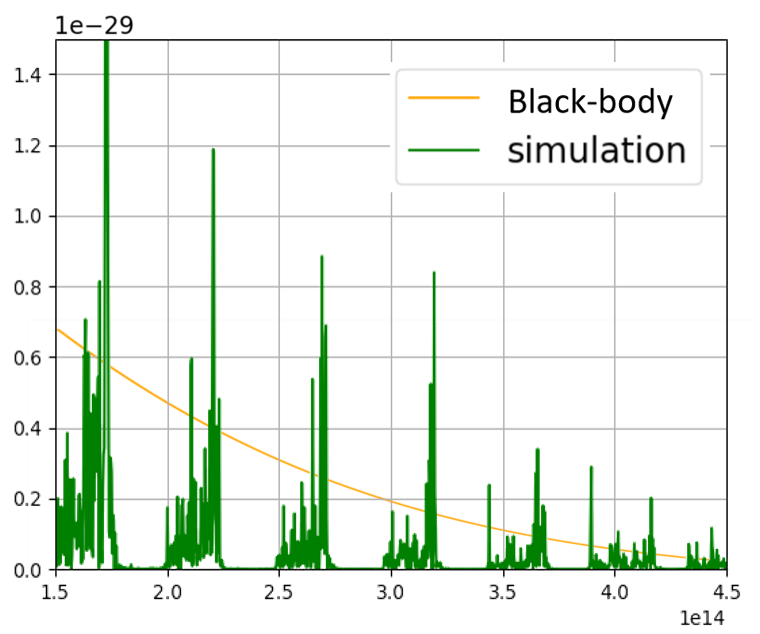

In [ ]:
freqs = np.linspace(1.5e14,4.5e14,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi*3/M,'g''-')
plt.xlim(1.5e14,4.5e14)
#plt.yscale("log")
#plt.ylim(0,1.5e-26)
plt.grid()
#plt.savefig('6AB1000.png')
plt.show()

#np.savez("6AB1000.npz", Efavg_30000 = Efavg)